In [1]:
%matplotlib inline

from pathlib import Path 
import os
import shutil
import random
import torch
from torch import nn
import torchvision
import numpy as np
# torch.utils.data import Dataset, Dataloader
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
import skimage.transform
import tqdm
torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)
print('tqdm', tqdm.__version__)

Using PyTorch version 1.7.0
tqdm 4.54.1


In [2]:
#shutil.rmtree('COVID-19 Radiography Database')

In [3]:
#!pip install --upgrade tqdm

In [4]:
path = Path(os.getcwd())/'COVID-19 Radiography Database'

In [5]:
os.listdir(path/'NORMAL')[0]

'NORMAL (398).png'

In [6]:
os.path.join("Detecting COVID-19 with Chest X-Ray using PyTorch",'NORMAL', os.listdir(path/'NORMAL')[0])

'Detecting COVID-19 with Chest X-Ray using PyTorch/NORMAL/NORMAL (398).png'

In [7]:
# show an image
def show_img(image_path, data_name):
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(data_name)
    plt.show()

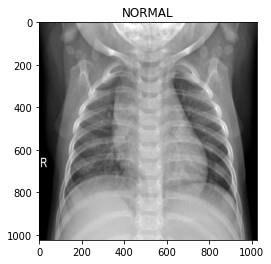

In [8]:
show_img(os.path.join("COVID-19 Radiography Database",'NORMAL', os.listdir(path/'NORMAL')[0]), 'NORMAL')

In [9]:
labels = ['COVID-19', 'NORMAL', 'Viral Pneumonia']
data_dir = 'COVID-19 Radiography Database'

In [10]:
imgs = {i:[i for i in os.listdir(os.path.join(data_dir,i)) if i.lower().endswith('png')] for i in labels}

In [11]:
imgs

{'COVID-19': ['COVID-19 (46).png',
  'COVID-19 (104).png',
  'COVID-19 (47).png',
  'COVID-19 (45).png',
  'COVID-19 (80).png',
  'COVID-19(202).png',
  'COVID-19(141).png',
  'COVID-19 (97).png',
  'COVID-19(163).png',
  'COVID-19 (3).png',
  'COVID-19 (131).png',
  'COVID-19 (52).png',
  'COVID-19 (33).png',
  'COVID-19 (68).png',
  'COVID-19 (63).png',
  'COVID-19 (38).png',
  'COVID-19(156).png',
  'COVID-19(139).png',
  'COVID-19(206).png',
  'COVID-19 (51).png',
  'COVID-19 (105).png',
  'COVID-19 (17).png',
  'COVID-19(199).png',
  'COVID-19(198).png',
  'COVID-19 (115).png',
  'COVID-19(169).png',
  'COVID-19 (60).png',
  'COVID-19 (128).png',
  'COVID-19(145).png',
  'COVID-19 (39).png',
  'COVID-19 (73).png',
  'COVID-19(143).png',
  'COVID-19(166).png',
  'COVID-19(185).png',
  'COVID-19 (8).png',
  'COVID-19 (2).png',
  'COVID-19(160).png',
  'COVID-19 (12).png',
  'COVID-19 (132).png',
  'COVID-19 (72).png',
  'COVID-19(201).png',
  'COVID-19(151).png',
  'COVID-19(219).pn

### Create test set
Take the n% of all images and put them to the folder "Test"

In [15]:
labels = ['COVID-19', 'NORMAL', 'Viral Pneumonia']
data_dir = 'COVID-19 Radiography Database'
imgs = {i:[i for i in os.listdir(os.path.join(data_dir,i)) if i.lower().endswith('png')] for i in labels}

In [16]:
os.mkdir(path/'test')
for c in labels:
    selected_images = random.sample(imgs[c], 30)
    os.mkdir(path/'test'/c)
    for image in selected_images:
        source_path = path/c/image
        target_path = path/'test'/c/image
        shutil.move(source_path, target_path)

## Dataset class

In [12]:
# Create custom dataset object

labels = ['COVID-19', 'NORMAL', 'Viral Pneumonia']  #labels and folder names
train_dir = 'COVID-19 Radiography Database'          # directory with images
test_dir = 'COVID-19 Radiography Database/test'

class Dataset(torch.utils.data.Dataset):
    # Constructor
    def __init__(self, labels, data_dir, transform=None):
        # Image directory
        self.data_dir=data_dir
        self.labels = labels
        self.imgs = {i:[i for i in os.listdir(os.path.join(self.data_dir,i)) if i.lower().endswith('png')] for i in self.labels}
        # The transform is goint to be used on image
        self.transform = transform
    # Get the length
    def __len__(self):
        self.len = sum([len(self.imgs[i]) for i in self.labels])
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        class_name = random.choice(self.labels)
        img_numb = idx % len(self.imgs[class_name])
        # Image file path
        img_name=os.path.join(self.data_dir,class_name,self.imgs[class_name][img_numb])
        # Open image file
        image = Image.open(img_name).convert('RGB')
        # The class label for the image
        y = class_name
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
            
        return image, self.labels.index(class_name)

### Image transformation

In [13]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# without flip
test_transform = torchvision.transforms.Compose([   
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

display_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224))])

In [14]:
train_dataset = Dataset(labels, train_dir, transform=train_transform)
test_dataset = Dataset(labels, data_dir=path/'test', transform=test_transform)

### Visualize what did we get

In [15]:
train_dataset[10][0].shape, train_dataset[10][1]

(torch.Size([3, 224, 224]), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


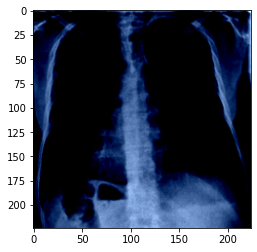

In [16]:
plt.imshow((train_dataset[101][0].permute(1, 2, 0)))

### Create a Dataloader

In [17]:
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = 8)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = 8)

In [18]:
print('Number of train batches: ',len(dl_test))

Number of train batches:  12


### Data Visualization

In [19]:
class_names = train_dataset.labels


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 8, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{(class_names[labels[i]])}')
        plt.ylabel(f'{class_names[preds[i]]}', color=col)
    plt.tight_layout()
    plt.show()

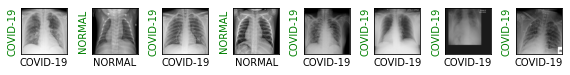

In [20]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

## Creating the Model

In [21]:
# if FloatProgress error  use -- >>  !pip install ipywidgets --upgrade
resnet18 = torchvision.models.resnet18(pretrained=True, progress=None)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [23]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_train))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

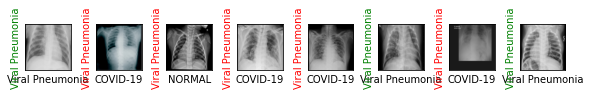

In [24]:
show_preds()

In [25]:
# without test set
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/3


/jet/var/python/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Evaluating at step 0
Validation Loss: 1.1981, Accuracy: 0.2778


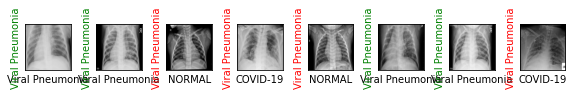

Evaluating at step 20
Validation Loss: 0.4827, Accuracy: 0.9222


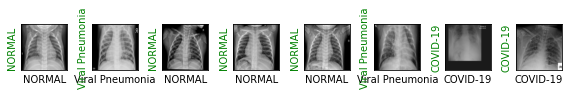

Evaluating at step 40
Validation Loss: 0.1915, Accuracy: 0.9667


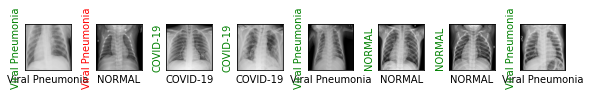

Performance condition satisfied, stopping..
CPU times: user 2min 46s, sys: 1.81 s, total: 2min 48s
Wall time: 49.3 s


In [26]:
%%time

train(epochs=3)

### GRAD CAM (Class activation mapping) (ver 1)

In [27]:
#list(resnet18.children())[:-1]

In [86]:
 class grad_cam(torch.nn.Module):
        def __init__(self):
            super(grad_cam, self).__init__()
            
            # get the trained network
            self.model = resnet18
            
            # cut the model by the last convolution layer
            self.features_conv = torch.nn.Sequential(*list(self.model.children())[:-2])
            
            # get avgpooling
            self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
            
            # get classifier
            self.fc = self.model.fc
            
            # placeholder for the gradients
            self.gradients = None
        # hooks allow you to do things during backpropagation    
        # hook for the gradients of the activations
        def activations_hook(self, grad):
            self.gradients = grad
        
        def forward(self, x):
            x = self.features_conv(x)
            
            # register hook
            h = x.register_hook(self.activations_hook)  # hook to get the gradiants at the layer 4 (last Canv layer)
            
            # apply the pooling
            x = self.avg_pool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x
        # method for gradient extraction
        def get_activations_gradients(self):
            return self.gradients
        
        # method for activation axtraction
        def get_activations(self, x):
            return self.features_conv(x)

In [87]:
# make a forward path

# get image from dataloader
#img, lbl = next(iter(dl_test))



new_model = grad_cam()
new_model.eval()

grad_cam(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [88]:
# take the image
image = Image.open(path/"test"/"COVID-19"/"COVID-19 (59).png").convert('RGB')
tensor = test_transform(image)
tensor.shape

torch.Size([3, 224, 224])

In [89]:
pred = new_model(tensor.unsqueeze(0))
pred.argmax(dim=1)  # label = 0 (covid19)

tensor([0])

In [90]:
train_dataset.labels

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [91]:
pred, pred[:,0]

(tensor([[ 2.3702, -0.7467, -0.6397]], grad_fn=<AddmmBackward>),
 tensor([2.3702], grad_fn=<SelectBackward>))

In [95]:
# get the gradient of the output with respect to the parameters of the model
pred[:,0].backward()

In [53]:
# pull the gradients out of the model
gradients = new_model.get_activations_gradients()

In [521]:
gradients.shape

torch.Size([1, 512, 7, 7])

In [501]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0,2,3])

In [502]:
gradients.shape, pooled_gradients.shape  # mean thru the gradients

(torch.Size([1, 512, 7, 7]), torch.Size([512]))

In [41]:
# get the activations on the last convolutional layer     
#also work (no function):    new_model.features_conv(tensor.unsqueeze(0)).detach()
activations = new_model.get_activations(tensor.unsqueeze(0)).detach()

In [504]:
activations.shape

torch.Size([1, 512, 7, 7])

In [505]:
# weights the channels by corresponding gradients
for i in range(512):
    activations[:,i,:,:]*=pooled_gradients[i]

In [519]:
activations.shape

torch.Size([1, 512, 7, 7])

In [506]:
# avarage the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

In [507]:
# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)

In [508]:
# normalize the heatmap
heatmap = heatmap/torch.max(heatmap)

In [509]:
heatmap.squeeze()

tensor([[0.6906, 0.7798, 0.5264, 0.5705, 0.6697, 0.6219, 0.4655],
        [0.8387, 0.9093, 0.5271, 0.6281, 0.8785, 0.8912, 0.7198],
        [0.8455, 1.0000, 0.6408, 0.6617, 0.7270, 0.8000, 0.6559],
        [0.6381, 0.8523, 0.6597, 0.6682, 0.6122, 0.6876, 0.4852],
        [0.5681, 0.9091, 0.8267, 0.7667, 0.5725, 0.5215, 0.3479],
        [0.5086, 0.8261, 0.7723, 0.6595, 0.5609, 0.5237, 0.2740],
        [0.3297, 0.5238, 0.4730, 0.4853, 0.3711, 0.3334, 0.1666]])

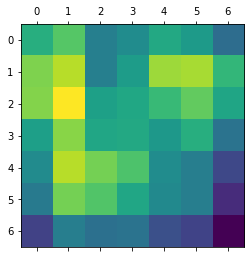

In [510]:
# draw the heatmap
plt.matshow(heatmap.squeeze())

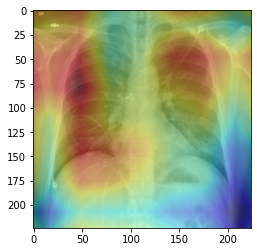

In [465]:
imshow(display_transform(image))
imshow(skimage.transform.resize(heatmap.squeeze(), tensor.shape[1:3]), alpha=0.4, cmap='jet');

In [511]:
a = [0,1,2,3,4,5]

In [512]:
a[:-2]

[0, 1, 2, 3]

### Class activation mapping (ver 2)
Try to understand, why network made the prediction it did

FastAI    https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb

 https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
 
 Pytorch hooks  https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/

In [173]:
final_layer = resnet18._modules.get('layer4')

In [174]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
    def remove(self): 
        self.hook.remove()

In [175]:
activated_features = SaveFeatures(final_layer)

In [180]:
prediction = resnet18(img[0].unsqueeze(0))

In [195]:
pred_probabilities = nn.functional.softmax(prediction).data.squeeze()
activated_features.remove()

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [197]:
torch.topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.9438]),
indices=tensor([0]))

In [198]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [200]:
weight_softmax_params = list(resnet18._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [201]:
weight_softmax_params

[Parameter containing:
 tensor([[ 0.0087,  0.0214,  0.0191,  ...,  0.0127,  0.0386, -0.0395],
         [-0.0192, -0.0435,  0.0264,  ...,  0.0323,  0.0232, -0.0128],
         [-0.0169,  0.0052,  0.0119,  ..., -0.0080, -0.0341, -0.0162]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0359, -0.0037,  0.0360], requires_grad=True)]

In [203]:
class_idx = torch.topk(pred_probabilities,1)[1].int()

In [204]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

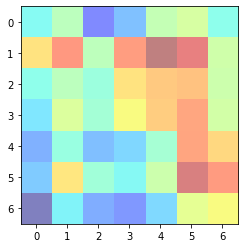

In [206]:
imshow(overlay[0], alpha=0.5, cmap='jet')

#### All together

In [384]:
final_layer = resnet18._modules.get('layer4')

class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
    def remove(self): 
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [385]:
image = Image.open(path/"test"/"COVID-19"/"COVID-19 (59).png").convert('RGB')

In [600]:
list(resnet18._modules.get('layer4').named_parameters())[3][1].shape

torch.Size([512, 512, 3, 3])

In [582]:
list(resnet18._modules.get('fc').parameters())

[Parameter containing:
 tensor([[ 0.0087,  0.0214,  0.0191,  ...,  0.0127,  0.0386, -0.0395],
         [-0.0192, -0.0435,  0.0264,  ...,  0.0323,  0.0232, -0.0128],
         [-0.0169,  0.0052,  0.0119,  ..., -0.0080, -0.0341, -0.0162]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0359, -0.0037,  0.0360], requires_grad=True)]

In [614]:
list(resnet18._modules.get('fc').parameters())[0]

Parameter containing:
tensor([[ 0.0087,  0.0214,  0.0191,  ...,  0.0127,  0.0386, -0.0395],
        [-0.0192, -0.0435,  0.0264,  ...,  0.0323,  0.0232, -0.0128],
        [-0.0169,  0.0052,  0.0119,  ..., -0.0080, -0.0341, -0.0162]],
       requires_grad=True)

In [580]:
list(resnet18.parameters())[-1]  # this is input to the final layer  ---  fc  layer

Parameter containing:
tensor([ 0.0359, -0.0037,  0.0360], requires_grad=True)

In [538]:
# length is 512 --- 512 channels in the 
len(list(resnet18.parameters())[-2][0])

512

prediction:  COVID-19
prediction:  COVID-19


/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


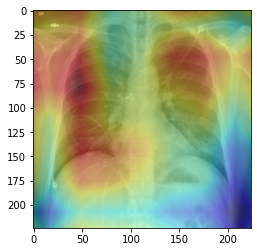

In [539]:
resnet18.eval()
tensor = test_transform(image)
print('prediction: ',train_dataset.labels[resnet18(tensor.unsqueeze(0)).argmax(1).numpy()[0]])
final_layer = resnet18._modules.get('layer4')
activated_features = SaveFeatures(final_layer)
prediction = resnet18(tensor.unsqueeze(0))
print('prediction: ',train_dataset.labels[prediction.argmax(1).numpy()[0]])
pred_probabilities = nn.functional.softmax(prediction).data.squeeze()
activated_features.remove()
weight_softmax_params = list(resnet18._modules.get('fc').parameters())  # same as list(resnet18.parameters())[-2]
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())  # take the weights for all classes
class_idx = torch.topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx)
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.4, cmap='jet');

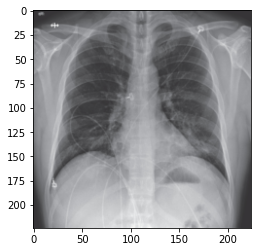

In [389]:
imshow(display_transform(image))